In [1]:
import os
import time
import math
import random

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from glob import glob

import cv2
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
data_dir = '/opt/ml/input/data'

train_path = os.path.join(data_dir, "train/images")
test_path = os.path.join(data_dir, "eval/images")

In [4]:
len(os.listdir(train_path)), len(os.listdir(test_path))

(5400, 25200)

In [5]:
os.listdir(train_path)[0]

'._005231_male_Asian_19'

In [6]:
os.listdir(train_path)[2]

'._006164_female_Asian_19'

In [62]:
import os
from glob import glob
from PIL import Image

import cv2
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit

os.chdir('/opt/ml/P-Stage/1-STAGE/')

def get_classes(key):
    """ predict하기 위해서는 순서가 중요하다. """
    if key == "mask":
        return ["wear", "incorrect", "not wear"]
    if key == "age":
        return ["age < 30", "30 <= age < 60", "60 <= age"]
    if key == "gender":
        return ["male", "female"]
    raise KeyError("key must be in ['mask', 'age', 'gender']")


def get_transforms(args):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    transform = transforms.Compose(
        [
            transforms.Resize((args.image_size, args.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )

    return transform


class MaskDataSet(Dataset):
    def __init__(self, args, is_train=True, transform=None):
        csv_file = os.path.join(args.data_dir, "train.csv")
        self.datas = pd.read_csv(csv_file)
        self.images, self.labels = self._load_image_files_path(args, is_train)
        self.label_idx = ["gender", "age", "mask"].index(args.train_key)

        if args.test:
            self.images, self.labels = self.images[:100], self.labels[:100]

        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(self.images[idx])

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx][self.label_idx]

    def __len__(self):
        return len(self.images)

    def _load_image_files_path(self, args, is_train):
        split = StratifiedShuffleSplit(
            n_splits=1,
            test_size=args.valid_size,
            random_state=0,  # 이 SEED값은 안 바꾸는 것이 좋다.
        )

        split_key = "age" if args.train_key == "age" else "gender"
        
        for train_index, valid_index in split.split(self.datas, self.datas[split_key]):
            train_dataset = self.datas.loc[train_index]
            valid_dataset = self.datas.loc[valid_index]
            
        assert len(set(train_dataset.index).intersection(set(valid_dataset.index))) == 0
        
        dataset = train_dataset if is_train else valid_dataset
        gender_classes = get_classes("gender")

        images = []
        labels = []

        for dir_name in dataset["path"]:
            dir_path = os.path.join(args.data_dir, "images", dir_name)

            image_id, gender_lbl, _, age_lbl = dir_name.split("_")

            gender_class = gender_classes.index(gender_lbl)

            # ["age < 30", "30 <= age < 60", "60 <= age"]
            age_lbl = int(age_lbl)

            if age_lbl < 30:
                age_class = 0
            elif age_lbl >= 60:
                age_class = 2
            else:
                age_class = 1

            for jpg_filepath in glob(dir_path + "/*"):
                jpg_basename = os.path.basename(jpg_filepath)

                if "normal" in jpg_basename:
                    mask_class = 2
                elif "incorrect" in jpg_basename:
                    mask_class = 1
                else:
                    mask_class = 0

                images.append(jpg_filepath)
                labels.append((gender_class, age_class, mask_class))

        return images, labels


def get_dataloader(args):
    transform = get_transforms(args)

    train_dataset = MaskDataSet(args, is_train=True, transform=transform)
    valid_dataset = MaskDataSet(args, is_train=False, transform=transform)

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.workers,
        pin_memory=True,
    )

    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.workers,
        pin_memory=True,
    )

    return train_dataloader, valid_dataloader

In [60]:
train_dataset.datas[train_dataset.datas['id'] == '003397']

,id,gender,race,age,path
1366,003397,female,Asian,20,003397_female_Asian_20
1367,003397,female,Asian,19,003397_female_Asian_19


In [61]:
train_dataset = MaskDataSet(args)

{'003397'}
1


In [13]:
train_dataset.datas.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [14]:
from sklearn.model_selection import train_test_split

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe854cff6d0>]],
      dtype=object)

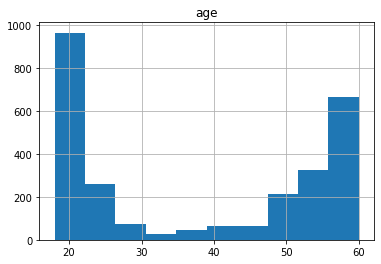

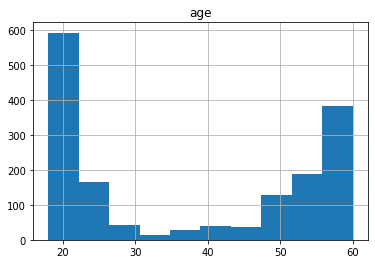

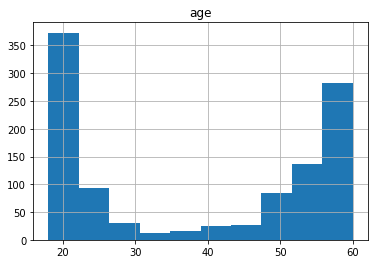

In [49]:
target = train_dataset.datas['gender']

train, test = train_test_split(train_dataset.datas, test_size=0.4, random_state=10, stratify=target)

train_dataset.datas.hist()
train.hist()
test.hist()

In [40]:
train_dataset.datas.groupby('age').count()

,id,gender,race,path
age,,,,
18,192,192,192,192
19,407,407,407,407
20,267,267,267,267
21,41,41,41,41
22,58,58,58,58
23,72,72,72,72
24,62,62,62,62
25,82,82,82,82
26,44,44,44,44


In [11]:
from config import get_args

args = get_args()

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

train_dataset = MaskDataSet(args, is_train=True, transform=transform)
valid_dataset = MaskDataSet(args, is_train=False, transform=transform)

In [85]:
len(train_dataset), len(valid_dataset)

(15120, 3780)

In [86]:
img, lbl = next(iter(train_dataset))

In [87]:
img.size, lbl

(<function Tensor.size>, (1, 56, 0))

In [73]:
full_img_list = glob(data_dir + "/train/images/*/*")

In [74]:
len(full_img_list) # folder: 2700, jpg: 18900

18900

In [70]:
full_img_list[0]

'/opt/ml/input/data/train/images/000523_female_Asian_51/mask4.jpg'

In [75]:
img, lbl = next(iter(train_dataset))

In [78]:
img.size, lbl

((384, 512), (1, 56, 0))

In [94]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [95]:
images, labels = next(iter(train_dataloader))

In [96]:
images.shape, labels

(torch.Size([8, 3, 224, 224]),
 [tensor([0, 1, 0, 1, 0, 0, 0, 0]),
  tensor([19, 19, 25, 19, 25, 36, 56, 21]),
  tensor([0, 0, 0, 0, 0, 0, 0, 1])])

In [97]:
labels[0]

tensor([0, 1, 0, 1, 0, 0, 0, 0])

![](https://s3-ap-northeast-2.amazonaws.com/aistages-public-junyeop/app/Users/00000025/files/56bd7d05-4eb8-4e3e-884d-18bd74dc4864..png)

In [1]:
mask = [0, 1, 2]
gender = [0, 1]
age = [0, 1, 2]

In [4]:
def get_class(mi, gi, ai):
    return 6 * mi + 3 * gi + ai

for mi in mask:
    for gi in gender:
        for ai in age:
            print(mi, gi, ai)
            print(get_class(mi, gi, ai))

0 0 0
0
0 0 1
1
0 0 2
2
0 1 0
3
0 1 1
4
0 1 2
5
1 0 0
6
1 0 1
7
1 0 2
8
1 1 0
9
1 1 1
10
1 1 2
11
2 0 0
12
2 0 1
13
2 0 2
14
2 1 0
15
2 1 1
16
2 1 2
17
